In [43]:
# This notebook handles data processing for the µ Lifetime lab

# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [44]:
# Fitting functions
def linear_fit(x, m, b):
    return x * m + b

In [45]:
# Reading files, plotting, and fitting

# Reads a data file, returning a dictionary of its data
def read_file(file: str, axes: tuple) -> list[dict, dict]:
    
    # The data read
    data = {}
    
    # Initialises data dictionaries
    for axis in axes:
        data[axis] = []
    
    
    # Reads the file
    with open(file, "r") as file:
        
        # Reads each line
        for line in file:
            
            # Deliminates each line with a comma
            split = line.split('\t')
            
            # Third line is the start of the data
            for i in range(len(axes)):
                    data[axes[i]].append(float(split[i]))
            
    # Returns
    return data

# Plots data
def plot(data, x_axis, title, labels = None, save = False, show = True, colour = None):
        
        if not colour:
            colour = 'tab:blue'
        
        # Obtains the figure components
        fig, ax = plt.subplots()
        
        # Creates the histogram
        bins = plt.bar([i for i in range(0, len(data.counts))], data.counts, color = colour)[0]

        # Adds axis titles
        if labels:
            plt.xlabel(labels[0])
            plt.ylabel(labels[1])
        
        # Adds a title
        plt.title(title)

        # Shows (or saves) the graph
        if not save and show:
            plt.show()
        elif save:
            plt.savefig(data.name + '.png', bbox_inches='tight')
            
def fit(x, y, fcn):
        # Performs the fit
        a_fit, cov = curve_fit(fcn, x, y)

        # Obtains the important parameters from the linear fit
        slope = a_fit[0]
        intercept = a_fit[1]

        # Obtains the uncertainty of the slope and intercept
        # Uncertainty is the square-root of the diagonal elements
        uncs = [np.sqrt(cov[i][i]) for i in range(len(cov))]

        return a_fit, uncs

In [46]:
# A class to contain our data
class Data:
    def __init__(self, file, axes):
        self.name = file
        self.data = read_file(file, axes)
        
    def __call__(self):
        return self.data
        
    def transform(self, axis, new_axis, params, fcn):
        self.data[new_axis] = []
        
        for i in range(len(self.data[axis])):
            self.data[new_axis].append(fcn(self.data[axis][i], params))
            
class Histogram(Data):
    def __init__(self, file, axes, bin_size):
        super().__init__(file, axes)

        self.counts = [0] * int(1e6)
        self.bin_size = bin_size
        
        self.histogram()
        
    def __class__(self):
        return 'Histogram'
        
        
    # Creates a histogram of the counts
    def histogram(self):
        for datum in self.data['diff']:
            self.counts[int(datum // self.bin_size)] += 1
            
        # Trims the trailing zeroes
        i = len(self.counts) - 1
        while self.counts[i] == 0:
            i -= 1
        self.counts = self.counts[:i + 1]
        
        
# Combines histograms without a Data class
# Assumes all histograms have the same bin size
class Histo:
    def __init__(self, histograms, bin_size = None, name = None):

        self.name = name
        
        if not bin_size:
            self.bin_size = histograms[0].bin_size
        else:
            self.bin_size = bin_size
        
        self.counts = []
        
        
        if histograms[0].__class__() == 'Histogram':
            for histogram in histograms:
                self.add_histogram(histogram)
        else:
            self.counts = histograms
            
    def __class__(self):
        return 'Histo'
        
    def add_histogram(self, histogram):
        for i in range(len(histogram.counts)):
            if i >= len(self.counts):
                self.counts.append(0)
        
            self.counts[i] += histogram.counts[i]
        
            

In [47]:
# Reads our data
days = ['day1', 'day2', 'day3', 'day4']

# The axes of our data file
#  diff is the time difference between the events (the important one!), in microseconds...probably
#  time is the time since the program started of the measurement, in seconds
# since is the time since the previous measurement, in seconds
axes = ['diff', 'time', 'since']

bin_size = 1

trials = [Histogram(day, axes, bin_size) for day in days]
histo = Histo(trials, name = 'combined')

# Converts the histogram to a natural logarithm of counts
ln_counts = []
for count in histo.counts:
    if count != 0:
        ln_counts.append(np.log(count))
    else:
        ln_counts.append(0)
listo = Histo(ln_counts, histo.bin_size, name = 'combined log')


In [48]:
# Does the maths

# First gets the count, but removes extra zeroes
x = [i * listo.bin_size for i in range(len(listo.counts)) if listo.counts[i] > 0]
y = [count for count in listo.counts if count > 0]

total_counts = sum(histo.counts)
counts_per_day = total_counts / (5 * 7)
counts_per_second = counts_per_day / 86400
oom = 5 * 86400 * 5 * 7

a_fit, cov = curve_fit(linear_fit, x, y)
uncs = [np.sqrt(cov[i][i]) for i in range(len(cov))]

m = a_fit[0]
b = a_fit[1]

tau = - 1 / m
d_tau = uncs[0] / (tau ** 2)

print(f'tau:\t{tau}')
print(f'∆tau:\t{d_tau}')


print(f'{round(a_fit[0], 2)} ± {round(uncs[0], 2)} $\mu s^-1$')
print(f'{round(tau, 2)} ± {round(d_tau, 2)} $\mu s$')

print(f'\n{listo.counts}')
print(len(listo.counts))
print(total_counts, counts_per_day, counts_per_second)
print(oom, total_counts / oom)

tau:	2.2326831848903286
∆tau:	0.0050984317617025175
-0.45 ± 0.03 $\mu s^-1$
2.23 ± 0.01 $\mu s$

[5.720311776607412, 5.918893854273146, 5.43372200355424, 4.897839799950911, 4.430816798843313, 3.970291913552122, 3.044522437723423, 3.332204510175204, 2.3978952727983707, 2.70805020110221, 1.9459101490553132, 0.6931471805599453, 0.6931471805599453, 0.0, 0, 0.0, 0, 0.0, 0, 0, 0, 0.0, 0.0]
23
1268 36.22857142857143 0.0004193121693121693
15120000 8.386243386243386e-05


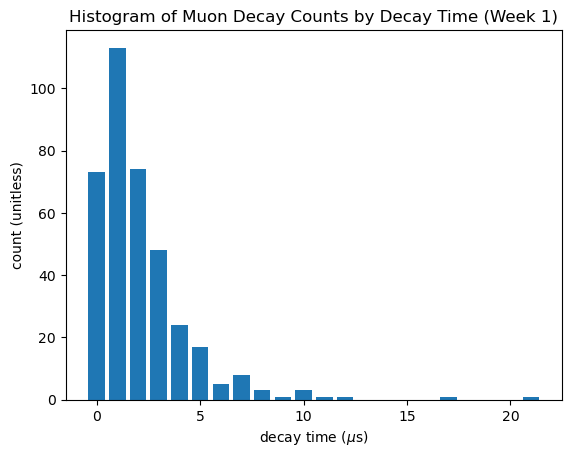

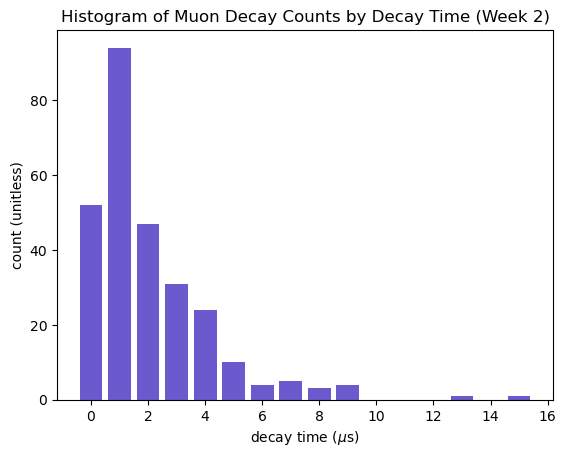

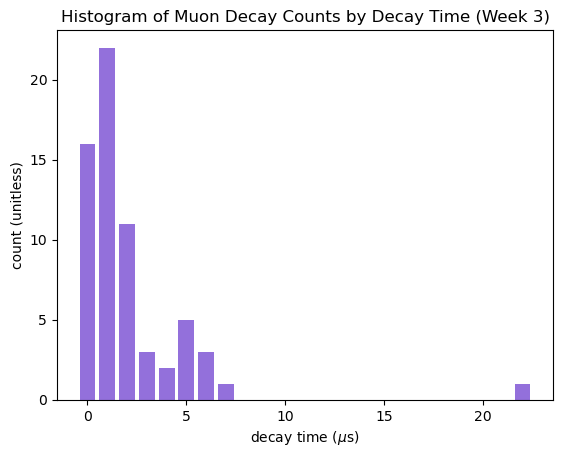

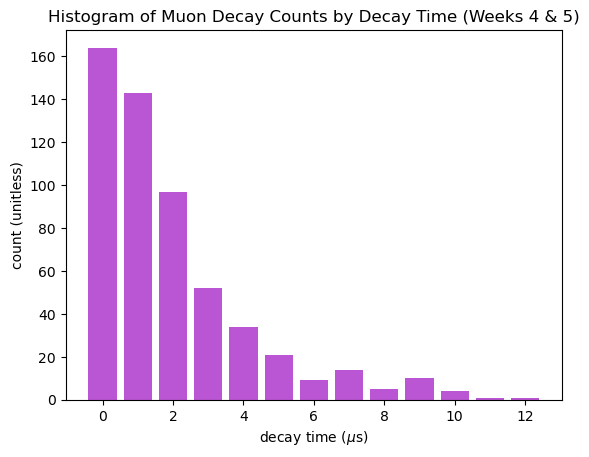

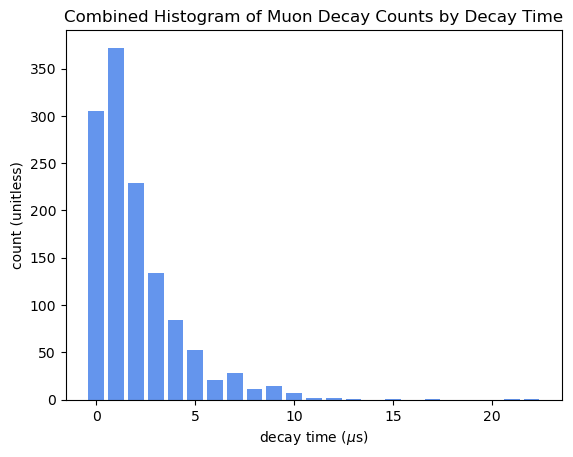

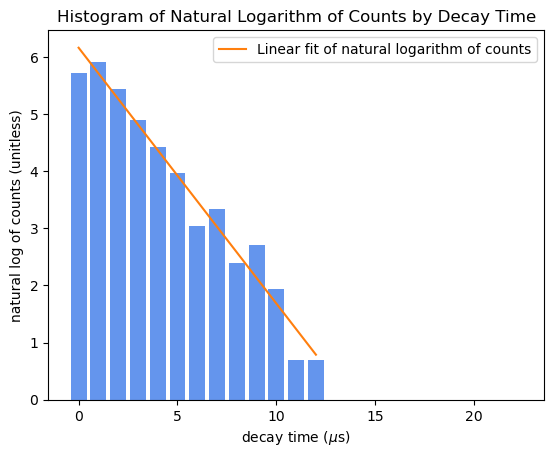

In [42]:
# Plots
save = True

colours = [
    'tab:blue',
    'slateblue',
    'mediumpurple',
    'mediumorchid'
]

for i in range(len(trials)):
    if i < 3:
        plot(trials[i], 'diff', f'Histogram of Muon Decay Counts by Decay Time (Week {trials[i].name[3:]})', ['decay time ($\mu$s)', 'count (unitless)'], save = save, colour = colours[i])
    else:
        plot(trials[i], 'diff', f'Histogram of Muon Decay Counts by Decay Time (Weeks 4 & 5)', ['decay time ($\mu$s)', 'count (unitless)'], save = save, colour = colours[i])
    
plot(histo, '-', f'Combined Histogram of Muon Decay Counts by Decay Time', ['decay time ($\mu$s)', 'count (unitless)'], save = save, colour = 'cornflowerblue')


plot(listo, '–', f'Histogram of Natural Logarithm of Counts by Decay Time', ['decay time ($\mu$s)', 'natural log of counts (unitless)'], save = False, show = False, colour = 'cornflowerblue')
plt.plot(x, [linear_fit(i * listo.bin_size, m, b) for i in x], color = 'tab:orange', label = 'Linear fit of natural logarithm of counts')
plt.legend()

if not save:
    plt.show()
else:
    plt.savefig(listo.name + '.png', bbox_inches='tight')

In [33]:
for i in range(len(histo.counts)):
    print(f'{round(i * histo.bin_size, 2)}:\t{histo.counts[i]}')

0.0:	105
0.1:	26
0.2:	2
0.3:	0
0.4:	0
0.5:	30
0.6:	50
0.7:	0
0.8:	92
0.9:	68
1.0:	0
1.1:	113
1.2:	35
1.3:	24
1.4:	31
1.5:	0
1.6:	41
1.7:	26
1.8:	34
1.9:	31
2.0:	35
2.1:	0
2.2:	50
2.3:	20
2.4:	15
2.5:	13
2.6:	0
2.7:	48
2.8:	17
2.9:	18
3.0:	16
3.1:	0
3.2:	29
3.3:	16
3.4:	17
3.5:	9
3.6:	7
3.7:	13
3.8:	9
3.9:	16
4.0:	8
4.1:	7
4.2:	10
4.3:	0
4.4:	15
4.5:	5
4.6:	6
4.7:	6
4.8:	0
4.9:	19
5.0:	4
5.1:	5
5.2:	8
5.3:	0
5.4:	9
5.5:	7
5.6:	4
5.7:	3
5.8:	0
5.9:	7
6.0:	3
6.1:	1
6.2:	3
6.3:	0
6.4:	6
6.5:	2
6.6:	1
6.7:	2
6.8:	1
6.9:	1
7.0:	2
7.1:	4
7.2:	3
7.3:	1
7.4:	4
7.5:	1
7.6:	6
7.7:	4
7.8:	2
7.9:	0
8.0:	2
8.1:	4
8.2:	0
8.3:	2
8.4:	0
8.5:	0
8.6:	1
8.7:	0
8.8:	2
8.9:	1
9.0:	3
9.1:	2
9.2:	0
9.3:	3
9.4:	1
9.5:	1
9.6:	3
9.7:	0
9.8:	1
9.9:	0
10.0:	2
10.1:	0
10.2:	0
10.3:	2
10.4:	0
10.5:	1
10.6:	2
10.7:	0
10.8:	0
10.9:	0
11.0:	0
11.1:	0
11.2:	0
11.3:	0
11.4:	1
11.5:	0
11.6:	0
11.7:	0
11.8:	1
11.9:	0
12.0:	1
12.1:	0
12.2:	0
12.3:	0
12.4:	0
12.5:	1
12.6:	0
12.7:	0
12.8:	0
12.9:	0
13.0:	0
13.1:	0
13.2:	0
13.